In [3]:
def findgiftis(FOLDER, ext):

    # Function goal: return nifti files within a directory

    # Detail: could be used for a file with any extension...

    # Inputs

    # FOLDER (directory to search)
    # ext (the suffix (.gii or .gii.gz))

    def fprintf(stream, format_spec, *args):
        stream.write(format_spec % args)
    import os
    import sys
    giftilist = list()
    for file in os.listdir(FOLDER):
        if not file.startswith('.') and file.endswith(ext):
            giftilist.append(os.path.join(FOLDER, file))
    fprintf(sys.stdout, "Found %d gifti files \n", len(giftilist))
    return(sorted(giftilist))

In [4]:
def make_gifti_list(base_folder, sessionstring, space):

    def fprintf(stream, format_spec, *args):
        stream.write(format_spec % args)

    import os
    import sys
    sessionlist = list()
    for session in os.listdir(base_folder):
        if not session.startswith('.') and session.startswith(tuple(sessionstring)):
            sessionlist.append(os.path.join(base_folder, session))
    fprintf(sys.stdout, "Found %d sessions \n", len(sessionlist))

    gifts = []

    for sess in sorted(sessionlist):
        gifts.append(findgiftis(os.path.join(sess, 'func'), '.gii'))

    flatgifts = []

    for sublist in gifts:
        for item in sublist:
            flatgifts.append(item)

    leftgifts = [gift for gift in flatgifts if space + "_hemi-L" in(gift)]
    rightgifts = [gift for gift in flatgifts if space + "_hemi-R" in(gift)]

    return leftgifts, rightgifts, gifts, flatgifts

In [5]:
mygifts=make_gifti_list('/Volumes/BAHAMUT/ALL_PRF_DAT/BIGRUN/derivatives/fmriprep/sub-02','ses','fsaverage')

Found 4 sessions 
Found 52 gifti files 
Found 32 gifti files 
Found 40 gifti files 
Found 60 gifti files 


In [7]:
from nilearn import surface

from joblib import Parallel, delayed

In [13]:
x=surface.load_surf_data(mygifts[0][0]).astype('float16')
type(x)

numpy.ndarray

In [14]:
x[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float16)

In [15]:
from nilearn import surface

from joblib import Parallel, delayed

In [26]:
def import_surf_astype(fn,fmt):
    impt=surface.load_surf_data(fn).astype(fmt)
    return impt

In [28]:
def import_gifts(flist, procs,fmt):
    gifts = Parallel(n_jobs=procs, verbose=9)(delayed(import_surf_astype)(fn,fmt) for fn in flist)
    return gifts

In [29]:
Lgifts=import_gifts(mygifts[0],5,'float32')

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    9.7s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   29.6s
[Parallel(n_jobs=5)]: Done  43 out of  46 | elapsed:   55.8s remaining:    3.9s
[Parallel(n_jobs=5)]: Done  46 out of  46 | elapsed:   58.3s finished


In [43]:
type(Lgifts[45][0,0])

numpy.float32

In [44]:
def savgol_filter(data, polyorder, deriv, window_length,tr,fmt):
    """ Applies a savitsky-golay filter to a nifti-file.

    Fits a savitsky-golay filter to a 4D fMRI nifti-file and subtracts the
    fitted data from the original data to effectively remove low-frequency
    signals.

    Parameters
    ----------
    in_file : str
        Absolute path to nifti-file.
    polyorder : int (default: 3)
        Order of polynomials to use in filter.
    deriv : int (default: 0)
        Number of derivatives to use in filter.
    window_length : int (default: 120)
        Window length in seconds.

    Returns
    -------
    out_file : str
        Absolute path to filtered nifti-file.


    Courtesy of knapenlab.
    """

    import nibabel as nib
    from scipy.signal import savgol_filter
    import numpy as np
    import os

    dims = data.shape
    

    # TR must be in seconds
    if tr < 0.01:
        tr = np.round(tr * 1000, decimals=3)
    if tr > 20:
        tr = tr / 1000.0

    window = np.int(window_length / tr)
    
    # Window must be odd
    if window % 2 == 0:
        window += 1

    data = data.reshape((np.prod(data.shape[:-1]), data.shape[-1]))
    data_filt = savgol_filter(data, window_length=window, polyorder=polyorder,
                              deriv=deriv, axis=1, mode='nearest')

    data_filt = data - data_filt + data_filt.mean(axis=-1)[:, np.newaxis]
    data_filt = data_filt.reshape(dims)
    data_filt=data_filt.astype(fmt)

    return data_filt

In [50]:
def perform_savgol (dlist, polyorder, deriv, window_length,tr,procs,fmt):
    filt_dat=Parallel(n_jobs=procs,verbose=9)(delayed(savgol_filter)(data,polyorder, deriv, window_length,tr,fmt)  for data in dlist)
    return filt_dat

In [51]:
Lfilt=perform_savgol(Lgifts,3,0,120,1.5,5,'float32')

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    8.1s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   17.6s
[Parallel(n_jobs=5)]: Done  43 out of  46 | elapsed:   31.8s remaining:    2.2s
[Parallel(n_jobs=5)]: Done  46 out of  46 | elapsed:   33.0s finished


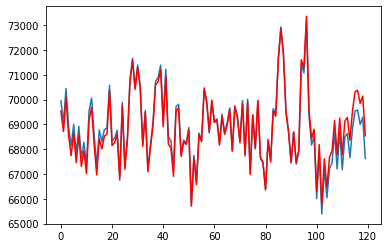

In [58]:
plt.plot(Lgifts[0][34,:])
plt.plot(Lfilt[0][34,:],'r')

In [60]:
def make_tsv_list(base_folder, sessionstring, space):

    def fprintf(stream, format_spec, *args):
        stream.write(format_spec % args)

    import os
    import sys
    sessionlist = list()
    for session in os.listdir(base_folder):
        if not session.startswith('.') and session.startswith(tuple(sessionstring)):
            sessionlist.append(os.path.join(base_folder, session))
    fprintf(sys.stdout, "Found %d sessions \n", len(sessionlist))

    gifts = []

    for sess in sorted(sessionlist):
        gifts.append(findgiftis(os.path.join(sess, 'func'), '.tsv'))

    flatgifts = []

    for sublist in gifts:
        for item in sublist:
            flatgifts.append(item)


    return gifts, flatgifts

In [61]:
mytsv=make_tsv_list('/Volumes/BAHAMUT/ALL_PRF_DAT/BIGRUN/derivatives/fmriprep/sub-02','ses','fsaverage')

Found 4 sessions 
Found 13 gifti files 
Found 8 gifti files 
Found 10 gifti files 
Found 15 gifti files 


In [65]:
len(mytsv[1])

46

In [66]:
len(Lfilt)

46

In [143]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from nistats.regression import OLSModel



def savgol_filter_1D(data, polyorder, deriv, window_length,TR):


    from scipy.signal import savgol_filter

    window = np.int(window_length / TR)

    # Window must be odd
    if window % 2 == 0:
        window += 1

    data_filt = savgol_filter(data, window_length=window, polyorder=polyorder,
                              deriv=deriv, mode='nearest')

    data_filtered = data - data_filt + data_filt.mean()

    return data_filtered



def denoise(data,nuissance,varr,n_components, polyorder, deriv, window_length,TR,fmt):
    df = pd.read_csv(nuissance, sep='\t', header=0,index_col=None)
    # get the wanted variables and do stuff with it
    nuissances = []
    for var in varr:
        # get wanted nuissance variables
        ndat = np.array(df[var])
        # fill in nans
        ndat[ndat=='n/a'] = np.nan
        # cast to float
        ndat = ndat.astype(fmt)
            # median fill nan values (i.e. first value )
        ndat[np.isnan(ndat)] = np.nanmedian(ndat)
            # temporally filter 
        filtered_data = savgol_filter_1D(ndat, polyorder, deriv, window_length,TR)
            # z-score (so that explained variance ratios is interpretable)
        filtered_data_z = (filtered_data - np.mean(filtered_data)) / np.std(filtered_data)
            # and append
        nuissances.append(filtered_data_z)

    nuissances = np.array(nuissances)    

        # now do pca and grab first 5:
    pca = PCA(n_components=n_components)  
    pcas = pca.fit_transform(nuissances.T)

    datashape = data.shape

        # do nuissance regression
    dm = np.hstack([np.ones((pcas.shape[0],1)),pcas]) # add intercept
    model = OLSModel(dm)
    fit = model.fit(data.reshape(-1,datashape[-1]).T)
    resid = fit.resid.T.reshape(datashape)
    resid += np.mean(data,axis=-1)[:,np.newaxis] # re-add the signal offset which was regressed out by the intercept
    return resid.astype(fmt), fit.theta.astype(fmt),fit.r_square.astype(fmt)


def perform_denoising (dlist,nlist,varr,n_components, polyorder, deriv, window_length,TR,procs,fmt):

    if len(nlist) != len(dlist):

        raise Exception("The number of datafiles and nuissance files do not match")

    denoised_dat=Parallel(n_jobs=procs,verbose=9)(delayed(denoise)(dlist[i],nlist[i],varr,n_components, polyorder, deriv, window_length,TR,fmt)  for i in range(len(dlist)))
    return denoised_dat

In [144]:
varr = ['std_dvars','dvars','framewise_displacement','a_comp_cor_00','a_comp_cor_01','a_comp_cor_02',
    'a_comp_cor_03',
    'a_comp_cor_04',
    'a_comp_cor_05',
    'trans_x',
    'trans_y',
    'trans_z',
    'rot_x',
    'rot_y',
    'rot_z',
    'cosine00']

In [145]:
denoised=perform_denoising(Lfilt,mytsv[1],varr,5,3,0,120,1.5,5,'float32')

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:   10.4s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:   21.2s
[Parallel(n_jobs=5)]: Done  43 out of  46 | elapsed:   37.7s remaining:    2.6s
[Parallel(n_jobs=5)]: Done  46 out of  46 | elapsed:   38.8s finished


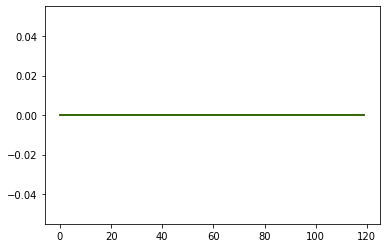

In [86]:
plt.plot(Lgifts[0][113,:])
plt.plot(Lfilt[0][113,:],'r')
plt.plot(denoised[0][0][113,:],'g')

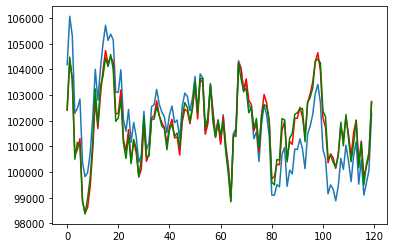

In [96]:
plt.plot(Lgifts[0][1192,:])
plt.plot(Lfilt[0][1192,:],'r')

plt.plot(denoised[0][0][1192,:],'g')

In [107]:
denoised[0][2].shape

(163842,)

In [110]:
def make_figspace(height,x,y):

    flatmap_height = height
    full_figsize = (x,y)

    full_fig = plt.figure(constrained_layout=True, figsize=full_figsize)
    return full_fig

full_fig=make_figspace(2048,20,16)

<Figure size 1440x1152 with 0 Axes>

In [118]:
def minimal_plot(sub,dat,zeronan,fig,savefig,fname):


    if zeronan==True:
        dat[dat==0]=np.nan

    light=cortex.Vertex(dat,subject=sub, vmin=np.nanmin(dat), vmax=np.nanmax(dat),cmap='plasma')
    mfig=cortex.quickshow(light,with_curvature=True,fig=fig,with_colorbar=True,with_rois=False)

    if savefig==True:
        mfig.savefig(fname, dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False, bbox_inches=None, pad_inches=0.1,frameon=None)

In [114]:
import cortex

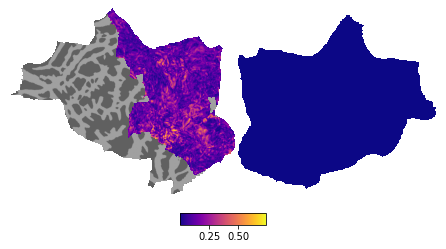

In [120]:
mfig=minimal_plot('02',denoised[0][2],True,full_fig,False,[])

In [121]:
path='/Volumes/BAHAMUT/pkg_tryout'


In [130]:
import nibabel
import os

In [198]:
def get_mean_noisefit(denoised_dat,export,sub,path,hem):
    R2s=[]
    bs=[]
    for dn in denoised_dat:
        R2s.append(np.nan_to_num(dn[2],0))
        bs.append(np.nan_to_num(dn[1],0))  




    bs=np.mean(bs,axis=0)    
    R2s=np.squeeze(np.mean(R2s,axis=0))

    if export:
        nibabel.freesurfer.io.write_morph_data(os.path.join(path,sub+'_'+hem+'noise_R2curv'),R2s)
        minimal_plot(sub,R2s,True,full_fig,True,os.path.join(path,sub+'_'+hem+'noise_R2.png'))

    for i in range(t.shape[0]):

        nibabel.freesurfer.io.write_morph_data(os.path.join(path,sub+'_'+hem+'pc'+str(i)+'noise_beta_curv'),R2s)
        minimal_plot(sub,bs[i,:],True,full_fig,True,os.path.join(path,sub+'_'+hem+'pc'+str(i)+'noise_beta.png'))



    return R2s, bs

In [170]:
def minimal_plot(sub,dat,zeronan,fig,savefig,fname):


    if zeronan==True:
        dat[dat==0]=np.nan

    light=cortex.Vertex(dat,subject=sub, vmin=np.nanmin(dat), vmax=np.nanmax(dat),cmap='plasma')
    mfig=cortex.quickshow(light,with_curvature=True,fig=fig,with_colorbar=True,with_rois=False)

    if savefig==True:
        mfig.savefig(fname, dpi=300, facecolor='w', edgecolor='w',orientation='portrait', papertype=None, format='png',transparent=False)


In [199]:
R2,bs =get_mean_noisefit(denoised,True,'02',path,'lh')

/Users/nicholashedger/anaconda2/envs/py3env/lib/python3.6/site-packages/cortex/quickflat/view.py:135: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_axes((0, 0, 1, 1))
/Users/nicholashedger/anaconda2/envs/py3env/lib/python3.6/site-packages/cortex/quickflat/composite.py:343: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  cbar = fig.add_axes(colorbar_location)
/Users/nicholashedger/anaconda2/envs/py3env/lib/python3.6/si

In [175]:
mydata=[]
for bits in denoised:
    mydata.append(bits[0])

In [176]:
def compute_tsnr(data,fmt):
    tsnr = np.mean(data,axis=-1)/np.std(data,axis=-1)
    tsnr[np.isnan(tsnr)] = 0
    tsnr[np.isinf(tsnr)] = 0
    tsnr += np.abs(np.min(tsnr))+0.01
    tsnr=np.squeeze(tsnr)
    return tsnr.astype(fmt) 


def perform_tsnring(dlist,procs,fmt):
    tsnr_dat=Parallel(n_jobs=procs,verbose=9)(delayed(compute_tsnr)(data,fmt)  for data in dlist)
    return tsnr_dat


In [177]:
tsnrs=perform_tsnring(mydata,5,'float32')

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:    1.7s
[Parallel(n_jobs=5)]: Done  22 tasks      | elapsed:    5.4s
[Parallel(n_jobs=5)]: Done  43 out of  46 | elapsed:   11.8s remaining:    0.8s
[Parallel(n_jobs=5)]: Done  46 out of  46 | elapsed:   12.6s finished


In [185]:
def export_tsnr(tsnr_dat,export,sub,path,hem):
    tsnr=[]
    for ts in tsnr_dat:
        tsnr.append(ts)


    tsnr=np.squeeze(np.mean(tsnr,axis=0))    

    if export:
        nibabel.freesurfer.io.write_morph_data(os.path.join(path,sub+'_'+hem+'tsnr_curv'),tsnr)
        minimal_plot(sub,tsnr,True,full_fig,True,os.path.join(path,sub+'_'+hem+'tsnr.png'))


    return tsnr

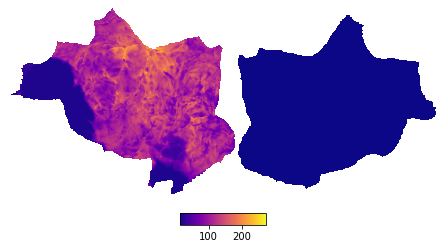

In [187]:
mtsnr=export_tsnr(tsnrs,True,'02',path,'lh')

In [237]:
np.nanmin(data)

0.0018716119

In [243]:
data=R2.astype('float64')


vdat = cortex.Vertex(data, subject='02',vmin=np.nanmin(data),vmax=np.nanmax(data),cmap='plasma')


cortex.webshow(vdat)

Started server on port 28428


<JS: window.viewer>

Stopping server


In [248]:
def make_webviewer_dict(sub,data,labels):


    mydict= {}

    for d in range(len(data)):
        data[d]=data[d].astype('float64')
        vdat = cortex.Vertex(data[d], subject=sub,vmin=np.nanmin(data[d]),vmax=np.nanmax(data[d]),cmap='plasma')
        mydict[labels[d]]=vdat

    return mydict

In [245]:
dlist=[mtsnr,R2]

In [246]:
llist=['tsnr','R2']

In [249]:
mdict=make_webviewer_dict('02',dlist,llist)

cortex.webshow(mdict)

Started server on port 16524


<JS: window.viewer>

Stopping server


TypeError: Object of type 'float32' is not JSON serializable

In [221]:
R2

array([0.1549731 , 0.14090267, 0.11654488, ..., 0.16383405, 0.16664457,
       0.17710474], dtype=float32)